# Atividade 6
# Fogo em Florestas
### Thaís Ferreira da Silva - 2021092571

In [430]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

## Plots

In [431]:
def plot_forest_map(forest, fire_start=None, fire_spread=None, title="Floresta", ax=None, subtitle=None):
    """
    Exibe o mapa da floresta com o estado atual das árvores e incêndios.
    """
    state_to_color = {0: 'white', 1: 'green', 2: 'orange', 3: 'red'}
    
    # Cria a representação RGB da floresta
    forest_rgb = np.zeros(forest.shape + (3,), dtype=float)
    for state, color in state_to_color.items():
        forest_rgb[forest == state] = mcolors.to_rgb(color)
    
    # Marca o início e o espalhamento do incêndio
    highlighted_cells = set()
    if fire_start:
        for (x, y) in fire_start:
            highlighted_cells.add((x, y)) 
            forest_rgb[x, y] = mcolors.to_rgb('red')  # Células onde o incêndio começou
    
    if fire_spread:
        for (x, y) in fire_spread:
            if (x, y) not in highlighted_cells:
                forest_rgb[x, y] = mcolors.to_rgb('orange')  # Células afetadas pelo incêndio
    
    # Plota o gráfico da floresta
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(forest_rgb)
    ax.set_title(title, fontsize=18, loc='center', pad=10)
    if subtitle:
        ax.set_title(subtitle, fontsize=12, loc='center', color='gray', pad=25)  # Subtítulo
    ax.axis('off')
    ax.grid(which='both', color='black', linestyle='-', linewidth=0.5)

    # Adiciona bordas e grades
    ax.set_xticks(np.arange(-0.5, forest.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, forest.shape[0], 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax.tick_params(which="minor", size=0)

    # Legenda
    legend_elements = [
        mpatches.Patch(color='white', label='Vazio'),
        mpatches.Patch(color='green', label='Árvore'),
        mpatches.Patch(color='orange', label='Incêndio'),
        mpatches.Patch(color='red', label='Raio')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=8)

def plot_fire_size_histogram(fire_sizes, L, p, f):
    if not fire_sizes:
        print("Nenhum incêndio ocorreu.")
        return
    plt.bar(range(1, len(fire_sizes) + 1), fire_sizes)
    plt.xlabel('Ordem dos Incêndios')
    plt.ylabel('Tamanho do Incêndio')
    plt.title(f'Distribuição do Tamanho dos Incêndios para L={L}, p={p}, f={f}')
    plt.show()

def propagate_fire(L, forest, fire_start):
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Vizinhança de von Neumann
    to_burn = [fire_start]
    burned = set()

    while to_burn:
        x, y = to_burn.pop()
        if (x, y) in burned:
            continue
        if forest[x, y] == 1:  # Se houver uma árvore
            forest[x, y] = 0  # Queima a árvore
            burned.add((x, y))
            for dx, dy in directions:
                nx, ny = (x + dx) % L, (y + dy) % L
                if forest[nx, ny] == 1 and (nx, ny) not in burned:
                    to_burn.append((nx, ny))
    return len(burned), burned

In [432]:
def calculate_ccdf_plot(fire_sizes, L):
    fire_sizes = np.array(fire_sizes)
    fire_sizes.sort()
    cCDF = np.array([(fire_sizes >= size).sum() for size in fire_sizes]) / len(fire_sizes)
    relative_sizes = fire_sizes / (L * L)
    
    # Plotting the cCDF
    plt.figure(figsize=(6, 6))
    plt.loglog(relative_sizes, cCDF, marker='o', linestyle='none')
    plt.xlabel('Tamanho relativo do incêndio (n/L²)')
    plt.ylabel('cCDF (C(n))')
    plt.title(f'cCDF para L={L}')
    plt.grid(True, which="both", linestyle="--")
    return relative_sizes, cCDF

def plot_cdffs_original_vs_random(sizes_original, ccdf_original, sizes_random, ccdf_random, L, p, f, steps):
    plt.figure(figsize=(8, 6))
    plt.plot(sizes_original, ccdf_original, label='Floresta Original', color='blue', marker='o', linestyle='None')
    plt.plot(sizes_random, ccdf_random, label='Floresta Aleatória', color='orange', marker='o', linestyle='None')
    plt.xlabel('Tamanho Relativo do Incêndio (n/L²)')
    plt.ylabel('cCDF, C(n)')
    plt.title(f'Distribuição de Tamanho do Incêndio para L={L}, p={p}, f={f}, T={steps}')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    plt.show()

# Função para ajuste de lei de potência
def fit_power_law(sizes, ccdf):
    log_sizes = np.log(sizes)
    log_ccdf = np.log(ccdf)
    slope, intercept = np.polyfit(log_sizes, log_ccdf, 1)
    return slope, intercept

# Função para plotar cCDF com o ajuste de lei de potência
def plot_cdff_original_alpha(sizes_original, ccdf_original, slope_original, intercept, alpha_original, L, p, f, steps):
    log_sizes = np.log(sizes_original)
    log_ccdf_fit = slope_original * log_sizes + intercept
    plt.figure(figsize=(8, 6))
    plt.plot(sizes_original, ccdf_original, label=f'Floresta Original (α={alpha_original:.2f})', color='blue', marker='o', linestyle='None')
    plt.plot(sizes_original, np.exp(log_ccdf_fit), label=f'Ajuste Linear (slope={slope_original:.2f})', color='red', linestyle='--')
    plt.xlabel('Tamanho Relativo do Incêndio (n/L²)')
    plt.ylabel('cCDF, C(n)')
    plt.title(f'Distribuição de Tamanho do Incêndio para L={L}, p={p}, f={f}, T={steps}')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()


## Funções de simulação

In [433]:
def calculate_ccdf_plot(fire_sizes, L):
    fire_sizes = np.array(fire_sizes)
    fire_sizes.sort()
    cCDF = np.array([(fire_sizes >= size).sum() for size in fire_sizes]) / len(fire_sizes)
    relative_sizes = fire_sizes / (L * L)
    
    return relative_sizes, cCDF

In [434]:
def simulate_forest(L, p, f, steps, somente_fogo=False):
    total_show = steps // 5
    forest = np.zeros((L, L), dtype=int)
    fire_sizes = []
    fire_info = []  # Lista para armazenar as informações sobre os incêndios

    # Controle de plots
    max_plots_per_figure = 3  # Número máximo de gráficos por figura
    plot_idx = 0  # Índice do subplot atual
    
    for step in range(steps):
        fire = False
        fire_start = []
        fire_spread = []
    
        # Crescimento das árvores
        growth = (np.random.rand(L, L) < p).astype(int)
        forest = forest + growth
        forest = np.clip(forest, 0, 1)
        initial_fire = forest.copy()
        
        # Verifica se um raio atinge uma célula
        if np.random.rand() < f:
            lightning_x, lightning_y = np.random.randint(L), np.random.randint(L)
            if forest[lightning_x, lightning_y] == 1:
                fire = True
                fire_start.append((lightning_x, lightning_y))
                cluster_size, spread_cells = propagate_fire(L, forest, (lightning_x, lightning_y))
                fire_sizes.append(cluster_size)
                fire_spread = spread_cells
                fire_info.append(f"Step:{step+1}. Fire started at ({lightning_x},{lightning_y}) and burned {cluster_size} trees.")
                
        # Plot da floresta a cada passo ou durante incêndios
        if (step+1) == 1 or (step+1) % total_show == 0 or (fire and cluster_size > 50):
            # Cria uma nova figura a cada 3 gráficos
            if plot_idx % max_plots_per_figure == 0:
                if plot_idx > 0:  # Se já houve gráficos antes, finaliza a figura anterior
                    plt.tight_layout()
                    plt.show()
                fig, axes = plt.subplots(1, max_plots_per_figure, figsize=(max_plots_per_figure * 5, 5))
                axes = axes.ravel()  # Garante que seja um array plano
            
            # Determina o índice no subplot
            current_ax = axes[plot_idx % max_plots_per_figure]
            plot_forest_map(forest, fire_start if fire else None, fire_spread if fire else None, 
                        title=f"Step {step+1}", ax=current_ax)
            plot_idx += 1
    
    # Exibe a última figura restante
    if plot_idx % max_plots_per_figure != 0:
        plt.tight_layout()
        plt.show()
    
    # Imprime todas as informações dos incêndios
    if fire_info:
        print("\nIncêndios ocorridos durante a simulação:")
        for info in fire_info:
            print(info)
    else:
        print("No fires occurred.")
    
    # Plota o histograma dos incêndios em uma figura separada com tamanho proporcional
    if fire_sizes:
        plt.figure(figsize=(6, 4))  # Definindo um tamanho proporcional (ajuste conforme necessário)
        plt.bar(range(1, len(fire_sizes) + 1), fire_sizes)
        plt.xlabel('Ordem dos Incêndios')
        plt.ylabel('Tamanho do Incêndio')
        plt.title(f'Distribuição do Tamanho dos Incêndios para L={L}, p={p}, f={f}')
        plt.tight_layout()  # Garantir que o layout seja adequado
        plt.show()
    else:
        print("No fires occurred.")


In [435]:
# Função para simular a floresta original
def simulate_forest_cdf(L_values, p, f, events):
    fig, axes = plt.subplots(1, len(L_values), figsize=(5 * len(L_values), 6))

    if len(L_values) == 1:
        axes = [axes]  # Garantir que axes é uma lista mesmo para um único subplot

    for i, L in enumerate(L_values):
        forest = np.zeros((L, L), dtype=int)
        fire_sizes = []

        for _ in range(events):
            # Crescimento das árvores
            growth = (np.random.rand(L, L) < p).astype(int)
            forest = forest + growth
            forest = np.clip(forest, 0, 1)

            # Verifica se um raio atinge uma célula
            if np.random.rand() < f:
                lightning_x, lightning_y = np.random.randint(L), np.random.randint(L)
                if forest[lightning_x, lightning_y] == 1:
                    cluster_size, _ = propagate_fire(L, forest, (lightning_x, lightning_y))
                    fire_sizes.append(cluster_size)

        # Calcula e plota a cCDF
        sizes, ccdf = calculate_ccdf_plot(fire_sizes, L)
        axes[i].loglog(sizes, ccdf, marker='o', linestyle='none')
        axes[i].set_title(f'L = {L}')
        axes[i].set_xlabel('Tamanho Relativo do Incêndio (n/L²)')
        axes[i].set_ylabel('cCDF, C(n)')
        axes[i].grid(True, which="both", linestyle="--")
    
    plt.tight_layout()
    plt.show()



In [436]:
def simulate_forest_vs_random(L, p_values, f, steps, alpha=False):
    fig, axes = plt.subplots(1, len(p_values), figsize=(5 * len(p_values), 6))

    if len(p_values) == 1:
        axes = [axes]  # Garantir que axes seja uma lista mesmo para um único subplot

    for i, p in enumerate(p_values):
        forest = np.zeros((L, L), dtype=int)
        fire_sizes_original = []
        fire_sizes_random = []

        for _ in range(steps):
            # Crescimento das árvores
            growth = (np.random.rand(L, L) < p).astype(int)
            forest = forest + growth
            forest = np.clip(forest, 0, 1)
            num_trees = np.sum(forest)
            
            # Verifica se um raio atinge uma célula
            if np.random.rand() < f:
                lightning_x, lightning_y = np.random.randint(L), np.random.randint(L)
                if forest[lightning_x, lightning_y] == 1:
                    # Incêndio na floresta original
                    cluster_size, _ = propagate_fire(L, forest, (lightning_x, lightning_y))
                    fire_sizes_original.append(cluster_size)
            
            # Cria uma floresta aleatória com o mesmo número de árvores
            random_forest = np.zeros((L, L), dtype=int)
            tree_positions = np.random.choice(L * L, num_trees, replace=False)
            random_forest[np.unravel_index(tree_positions, (L, L))] = 1
            
            # Inicia um incêndio aleatório na floresta gerada
            random_x, random_y = np.unravel_index(np.random.choice(tree_positions), (L, L))
            cluster_size_random, _ = propagate_fire(L, random_forest, (random_x, random_y))
            fire_sizes_random.append(cluster_size_random)

        # Calcula e plota a cCDF para a floresta original
        sizes_original, ccdf_original = calculate_ccdf_plot(fire_sizes_original, L)
        sizes_random, ccdf_random = calculate_ccdf_plot(fire_sizes_random, L)

        # Plotando cCDF
        axes[i].plot(sizes_original, ccdf_original, label='Floresta Original', color='blue', marker='o', linestyle='None')
        axes[i].plot(sizes_random, ccdf_random, label='Floresta Aleatória', color='orange', marker='o', linestyle='None')

        if alpha:
            # Calcula o ajuste linear (linha de potência) para a cCDF da floresta original
            slope_original, intercept = fit_power_law(sizes_original, ccdf_original)
            alpha_original = 1 - slope_original  # Cálculo do alpha
            plot_cdff_original_alpha(sizes_original, ccdf_original, slope_original, intercept, alpha_original, L, p, f, steps)

        axes[i].set_title(f'p = {p}')
        axes[i].set_xlabel('Tamanho Relativo do Incêndio (n/L²)')
        axes[i].set_ylabel('cCDF, C(n)')
        axes[i].legend()
        axes[i].grid(True, which="both", linestyle="--")
    
    plt.tight_layout()
    plt.show()


## Simualação

#### Parte 1 - Os tamanhos dos incêndios

Simulação a:


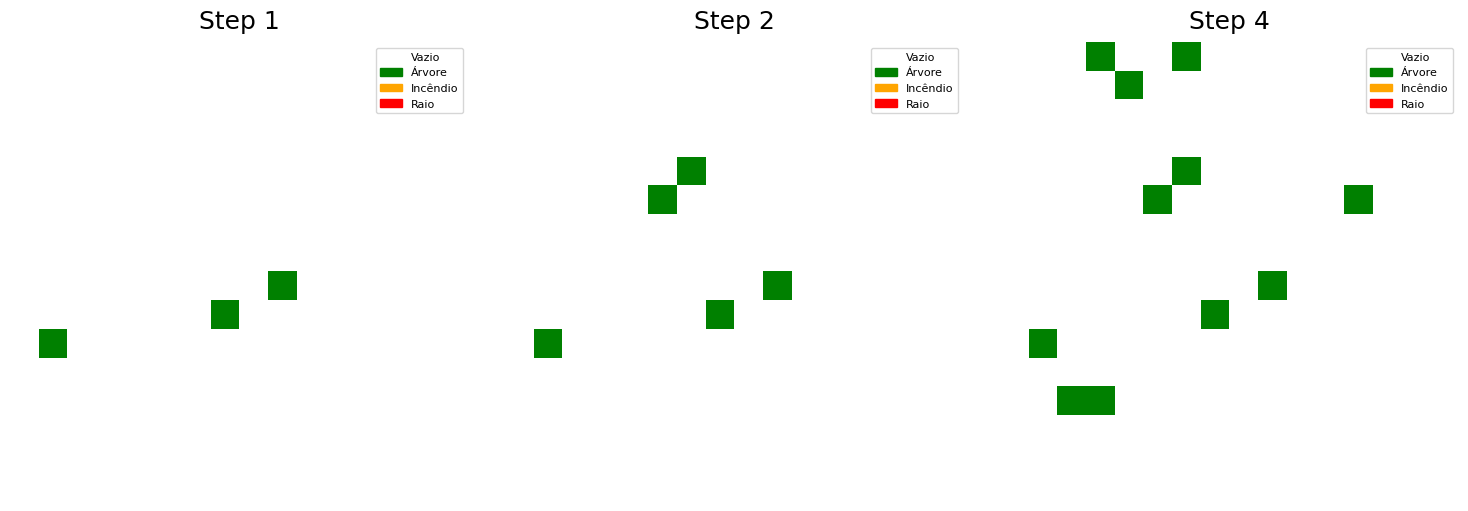

No fires occurred.
No fires occurred.


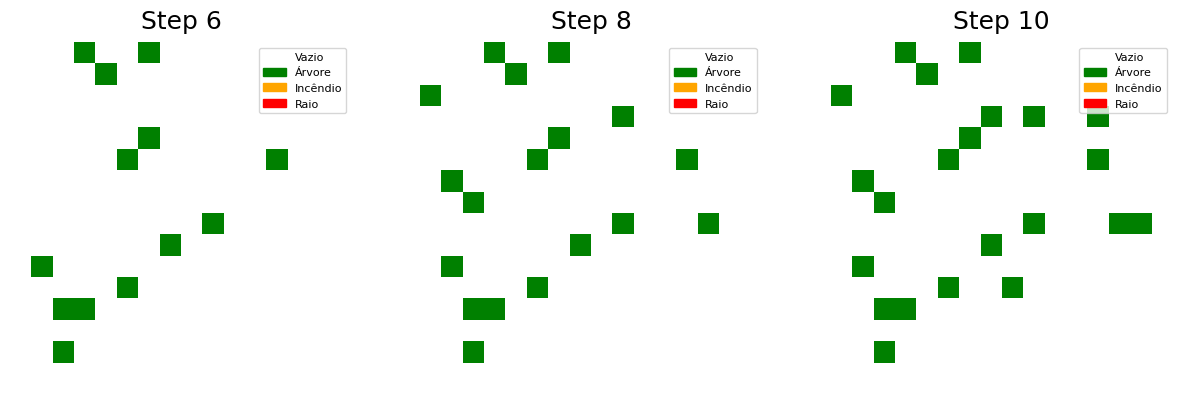

In [437]:
# tamanho da rede, prob de crescimento de arvores, prov de queda de raio, passos
print("Simulação a:")
simulate_forest(16, 0.01, 0.2, 10)


Simulação c:


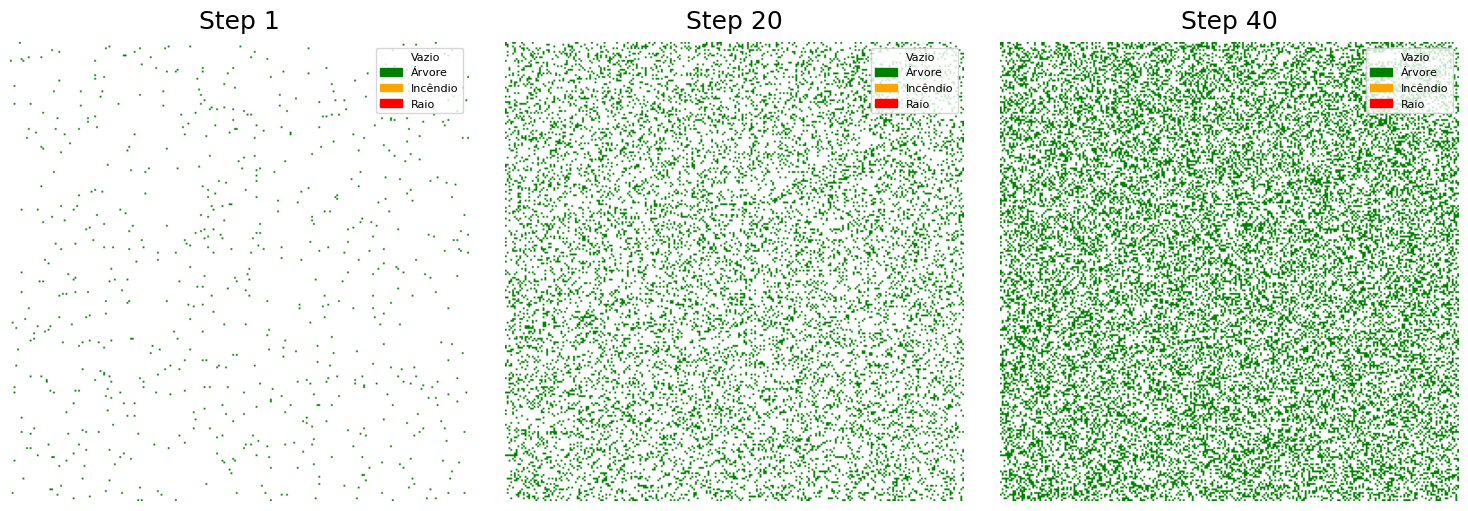

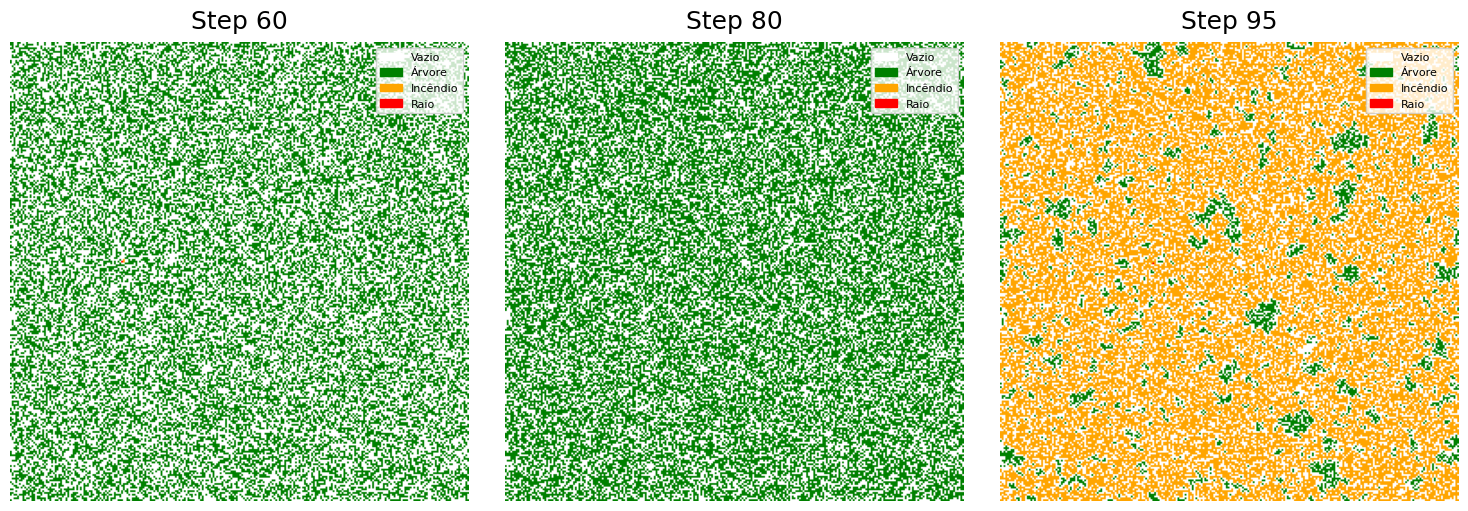

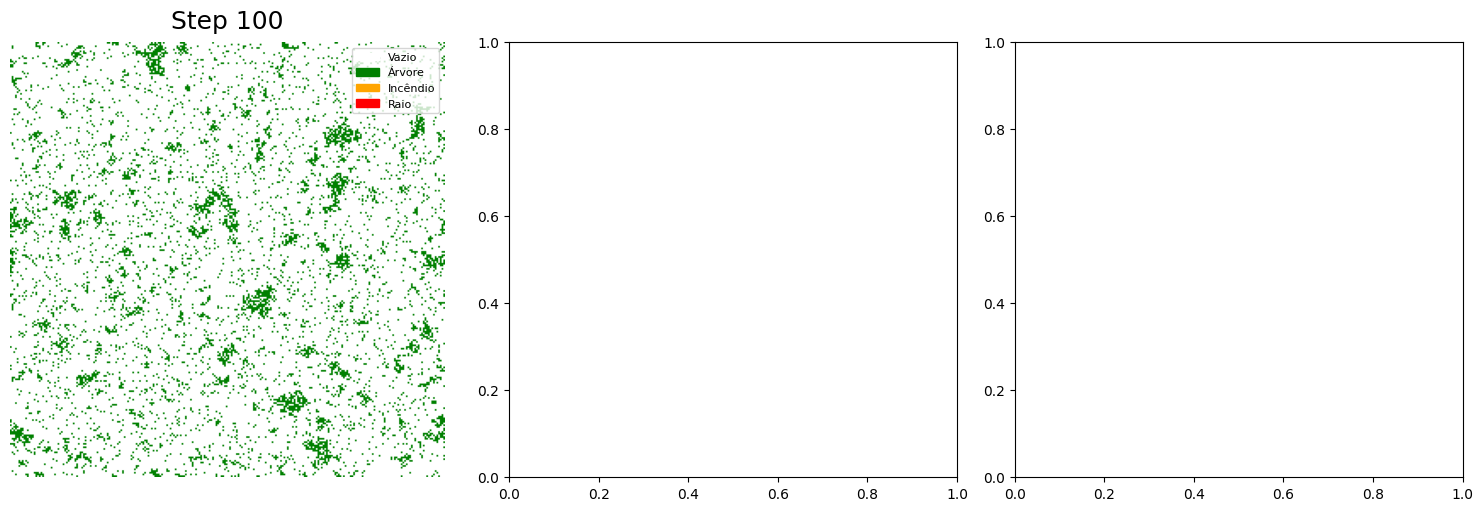


Incêndios ocorridos durante a simulação:
Step:5. Fire started at (226,105) and burned 2 trees.
Step:15. Fire started at (120,3) and burned 2 trees.
Step:35. Fire started at (213,204) and burned 1 trees.
Step:44. Fire started at (104,158) and burned 3 trees.
Step:59. Fire started at (123,87) and burned 12 trees.
Step:60. Fire started at (122,62) and burned 3 trees.
Step:81. Fire started at (168,175) and burned 28 trees.
Step:95. Fire started at (123,85) and burned 35910 trees.


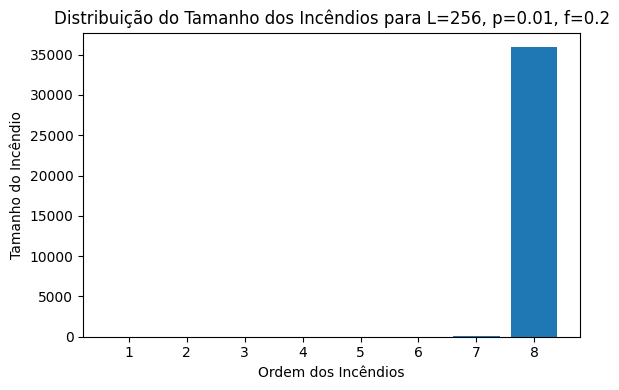

In [438]:
# tamanho da rede, prob de crescimento de arvores, prov de queda de raio, passos

print("\nSimulação c:")
simulate_forest(256, 0.01, 0.2, 104, True)

Observa-se que, conforme a floresta se expande, os incêndios começam menores e ocorrem com menor frequência nos primeiros estágios, dado os parâmetros utilizados. Porém, à medida que as árvores se espalham e passam a ter mais vizinhos conforme os passos avançam, a probabilidade de um incêndio atingir várias árvores aumenta. Isso pode levar a um incêndio de grande escala, que consome quase toda a floresta, retornando a um cenário onde os incêndios são mais raros e de menor intensidade.

#### Parte 2 - Distribuição de lei de potência dos incêndios florestais

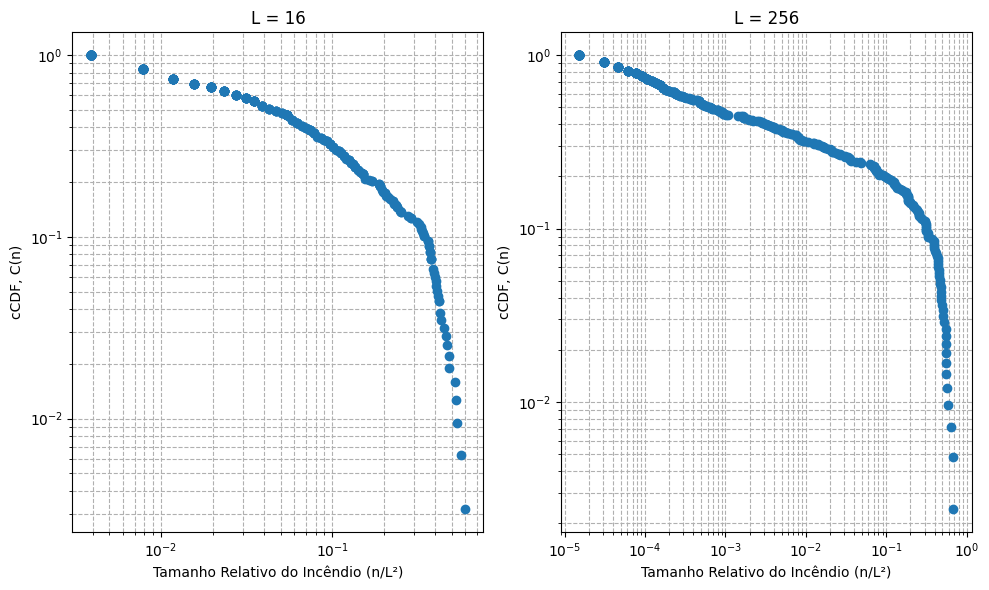

In [439]:
# tamanho da rede, prob de crescimento de arvores, prov de queda de raio, passos

simulate_forest_cdf([16, 256], 0.01, 0.2, 5000)


A cCDF apresenta um comportamento linear em escala log-log, sugerindo uma distribuição de lei de potência. Contudo, para L=16, essa linearidade tende a se desviar para incêndios de maior tamanho, devido ao limite do sistema e aos efeitos de borda. Incêndios grandes podem ocupar uma parte significativa da floresta, restringindo a propagação contínua do fogo.

Prolongamento da Seção Linear para L=256:
Com o aumento de L, a seção linear da cCDF se estende. Isso ocorre porque florestas maiores conseguem acomodar incêndios de maior escala, e a propagação do fogo em sistemas maiores segue mais de perto a distribuição de lei de potência, sem as limitações impostas pelas bordas. Como resultado, a seção linear no gráfico da cCDF se prolonga.

#### Parte 3 - Florestas afetadas por incêndios versus florestas aleatórias.

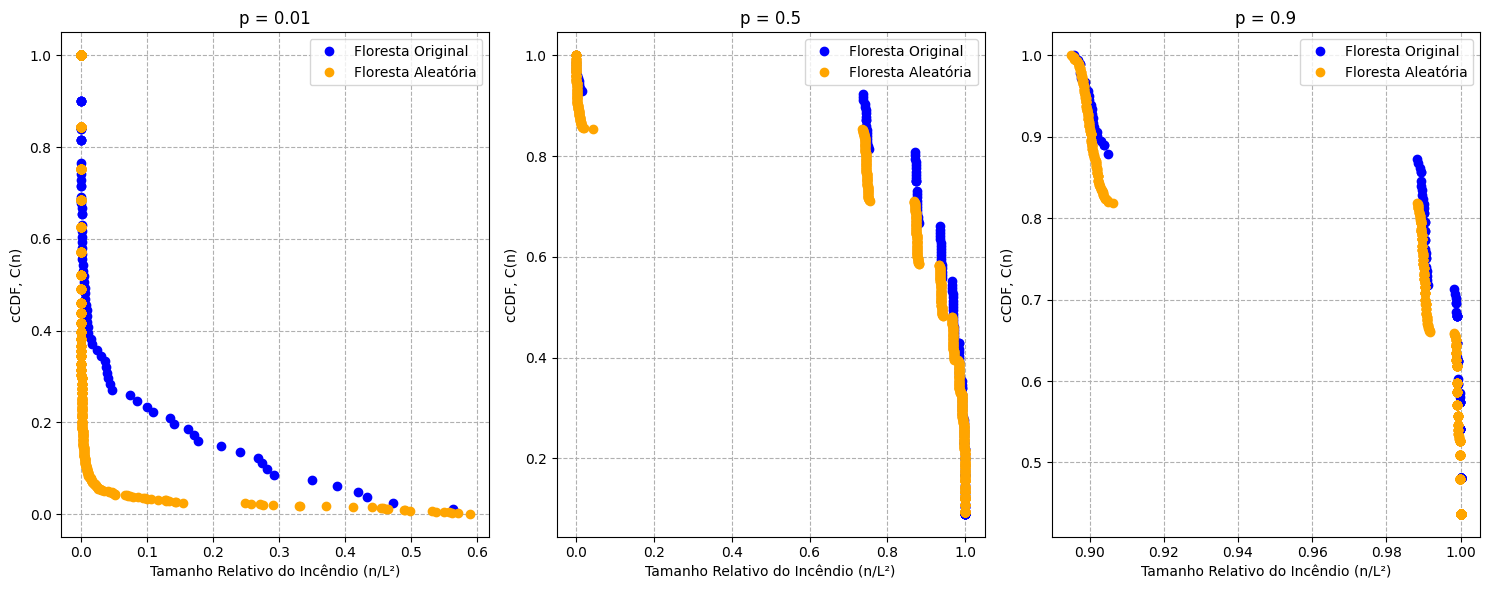

In [440]:
simulate_forest_vs_random(128, [0.01, 0.5, 0.9], 0.2, 1000)

A floresta que evolui naturalmente com incêndios exibe um comportamento distinto em comparação com a floresta aleatória, o que é evidenciado pela diferença entre as curvas da cCDF. O desvio da linearidade sugere que incêndios em florestas naturais são mais propensos a envolver um maior número de eventos de grandes incêndios, quando comparados às florestas aleatórias.

Observa-se que a distribuição dos incêndios entre as florestas permanece similar para altas probabilidades de crescimento das árvores. No entanto, à medida que a probabilidade de crescimento das árvores diminui e a probabilidade de incêndio aumenta, torna-se mais evidente que os incêndios em florestas naturais são mais intensos do que aqueles em florestas geradas aleatoriamente.

#### Parte 4 - Determinação do expoente α

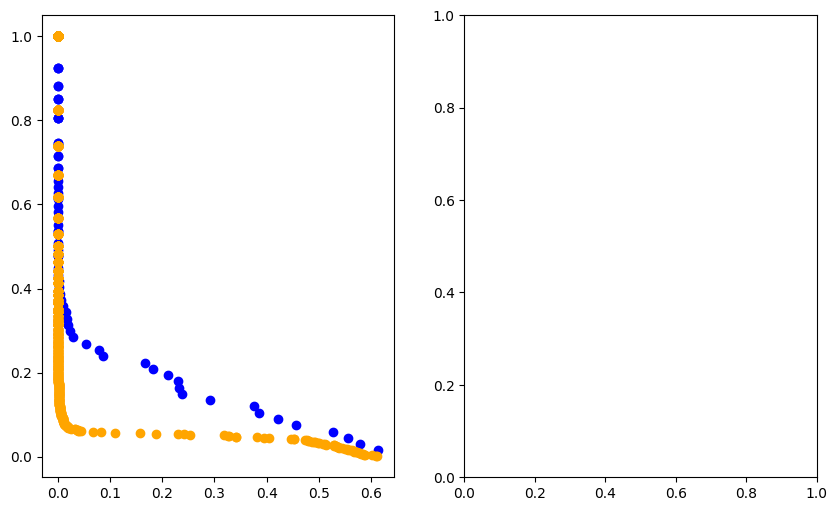

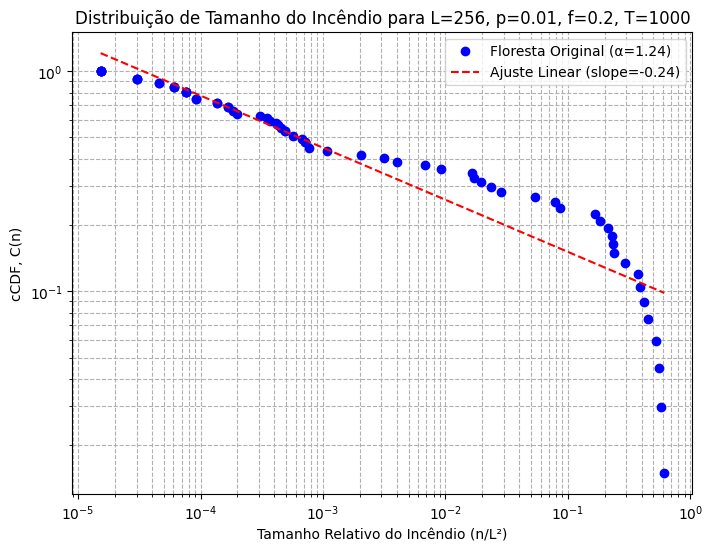

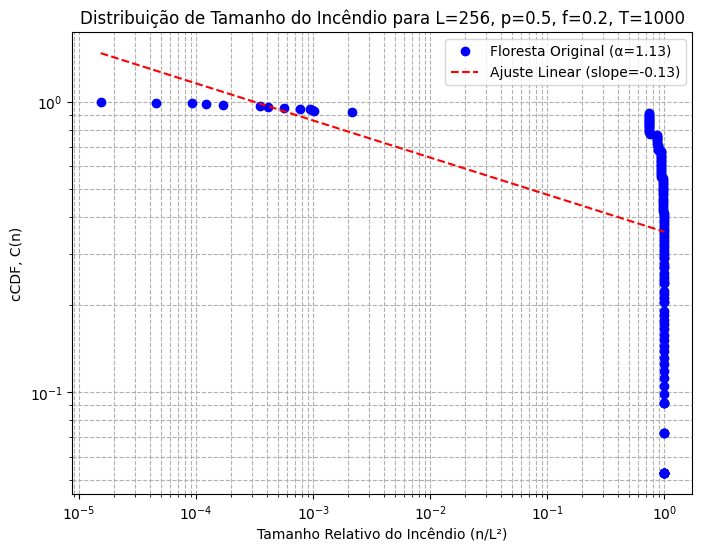

<Figure size 640x480 with 0 Axes>

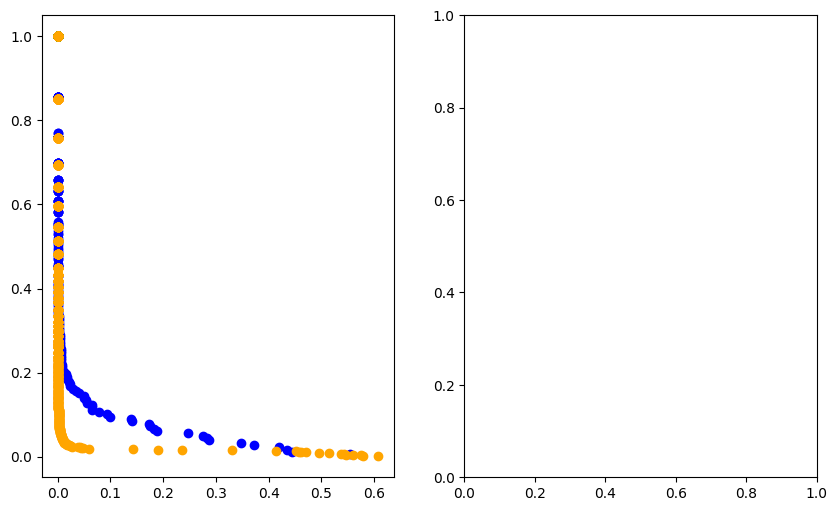

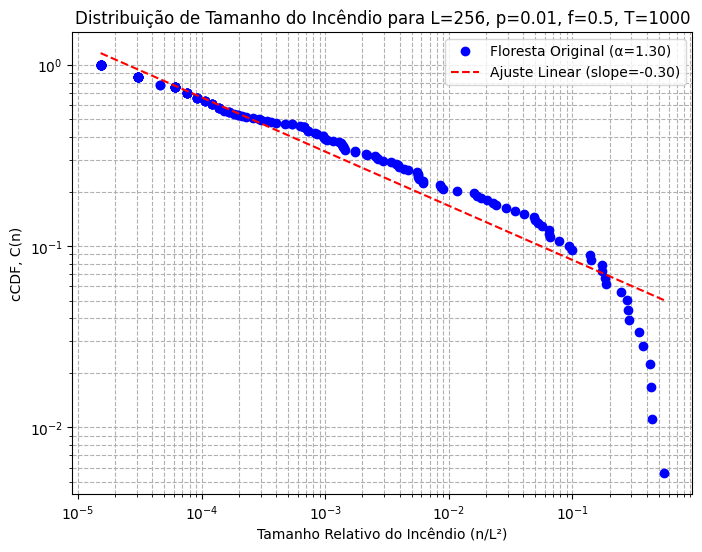

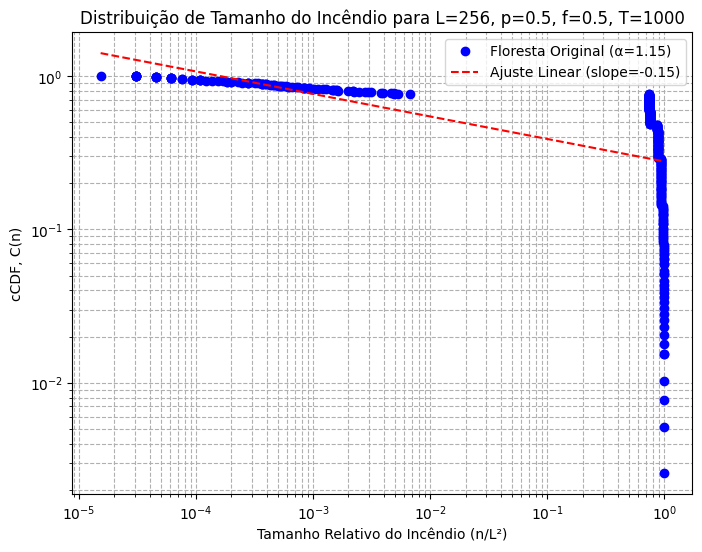

<Figure size 640x480 with 0 Axes>

In [441]:
simulate_forest_vs_random(256, [0.01, 0.5], 0.2, 1000, True)
simulate_forest_vs_random(256, [0.01, 0.5], 0.5, 1000, True)

O valor obtido para o nosso modelo é muito próximo ao valor de referência encontrado na literatura, que varia entre -1.15 e -1.24, com o nosso resultado sendo -1.24. Isso demonstra que a simulação gera resultados consistentes com a teoria das leis de potência aplicadas a incêndios florestais.

Além disso, é possível observar que o aumento da probabilidade de crescimento das árvores tem um impacto maior do que o aumento da probabilidade de ocorrência de um incêndio. Esse comportamento é esperado, pois uma maior aglomeração de árvores favorece a propagação de incêndios maiores na floresta.